In [84]:
include("src/qsrfe.jl")

Main.qsrfe

In [75]:
using Random
Random.seed!(1234)

TaskLocalRNG()

In [76]:
using LinearAlgebra
using MLJ, MLJLinearModels
X, Y = @load_boston
(xtrain, xtest), (ytrain, ytest) = qsrfe.load_dataset(X,Y;normalize=true,partitioning=0.8,rng=1234);
indexmaptrain = ytrain .<= 47
indexmaptest = ytest .<= 47
(xtrain, xtest), (ytrain, ytest) = (xtrain[indexmaptrain,:], xtest[indexmaptest,:]), (ytrain[indexmaptrain], ytest[indexmaptest]);

In [4]:
size(xtrain), size(xtest)

((389, 12), (98, 12))

In [5]:
using Plots

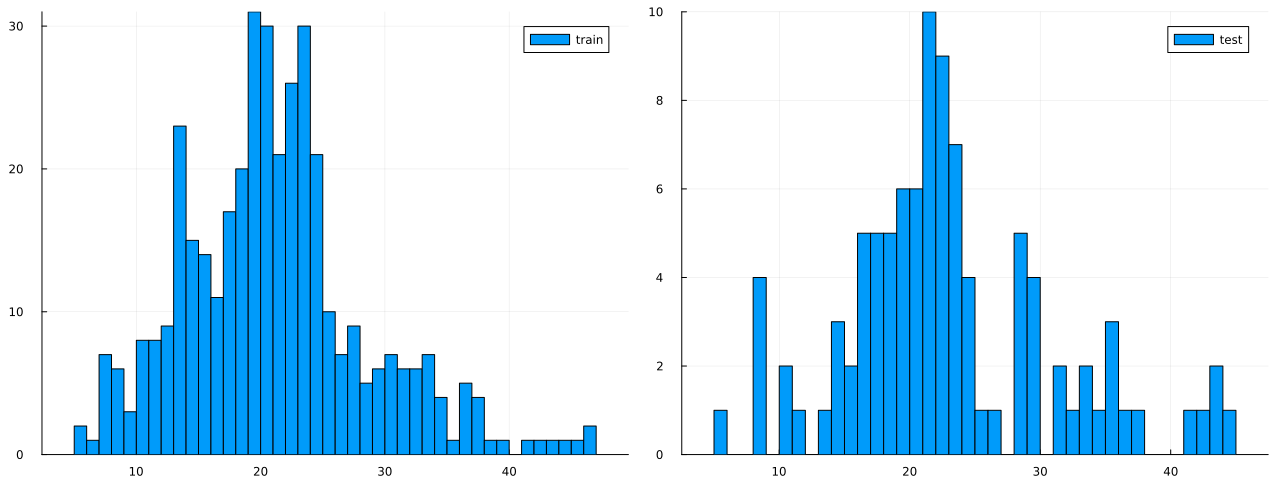

In [6]:
p1 = Plots.histogram(ytrain, label="train", bins=50)
p2 = Plots.histogram(ytest, label="test", bins=50)
plot(p1, p2, layout=(1,2), size= (1280,480),legend=true)

In [23]:
"2^8:", 2^8, "2^9:", 2^9, "2^10:", 2^10, "2^11:", 2^11, "2^12:", 2^12, "2^13:", 2^13, "2^14:", 2^14, "2^15:", 2^15, "2^16:", 2^16, "2^17:", 2^17

("2^8:", 256, "2^9:", 512, "2^10:", 1024, "2^11:", 2048, "2^12:", 4096, "2^13:", 8192, "2^14:", 16384, "2^15:", 32768, "2^16:", 65536, "2^17:", 131072)

In [32]:
# Assemble all the models to test
N = 2^13
SRFE = qsrfe.srfeRegressor(N=N,σ2=11.0,λ=0.003, intercept=true)
RFE = qsrfe.rfeRegressor(N=N,σ2=11.0,λ=0.003, intercept=true)

βQ = qsrfe.βQ(K=2,β=1.5,λ=16,condense=true)
;

In [77]:
using Profile

In [85]:
Profile.clear()

In [90]:
# Assemble all the models to test
N = 2^14
SRFE = qsrfe.srfeRegressor(N=N,σ2=10.0,λ=0.00006, intercept=true)
RFE = qsrfe.rfeRegressor(N=N,σ2=10.0,λ=0.001, intercept=true)
βQ = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)

#training and evaluating
model = SRFE
c = @profile qsrfe.fit(model, xtrain, ytrain,βQ, verbose=true) #,max_iter=2000000
ytrainpred = qsrfe.predict(model,xtrain,βQ)
ytestpred = qsrfe.predict(model, xtest,βQ)

;

support: 478/513


test rel: 0.15189448535035632 train rel: 0.0014831312028581452
test abs: 2.792992198114446 train abs: 0.024912003691226536
test mse: 13.589772108148791 train mse: 0.0011017393442640064
test rmse: 3.686430808810711 train rmse: 0.033192459147583606


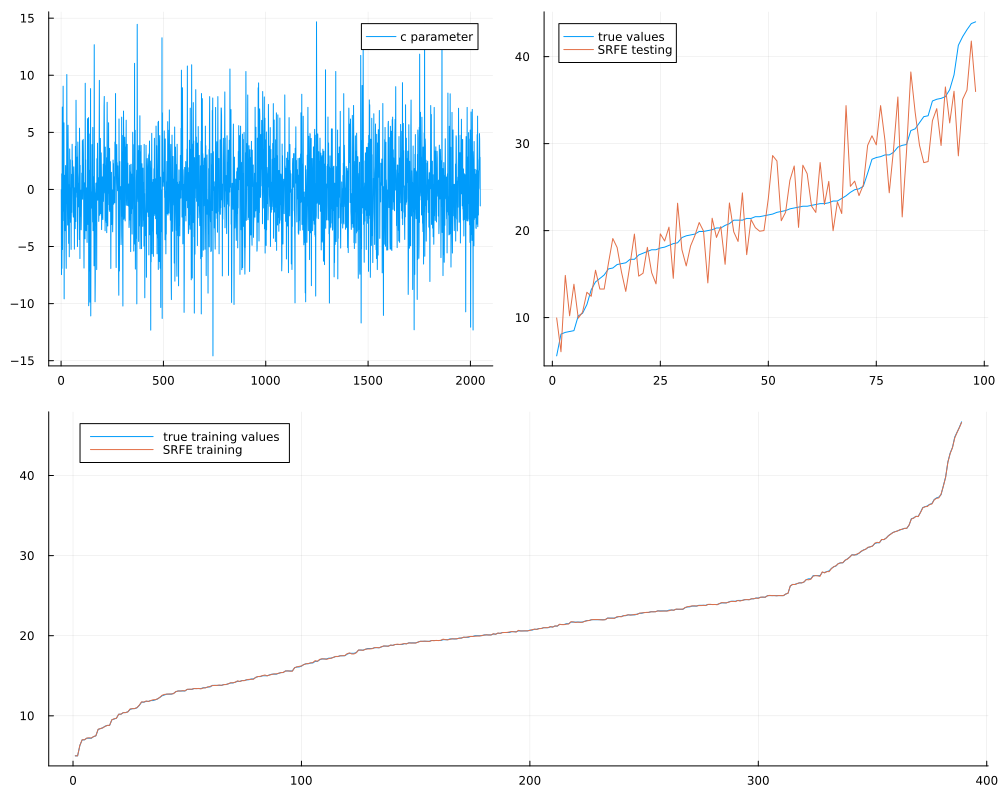

In [88]:
println("")
println("test rel: ",qsrfe.rel_L2_error(ytest,ytestpred)," train rel: ",qsrfe.rel_L2_error(ytrain,ytrainpred))
println("test abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("test mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
println("test rmse: ",qsrfe.rmse(ytest,ytestpred)," train rmse: ",qsrfe.rmse(ytrain,ytrainpred))
model = SRFE
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))


test rel: 0.15452224376527063 train rel: 0.14256700911533948
test abs: 3.0067844855192445 train abs: 2.622439387182839
test mse: 15.678034745967434 train mse: 12.57256746626774


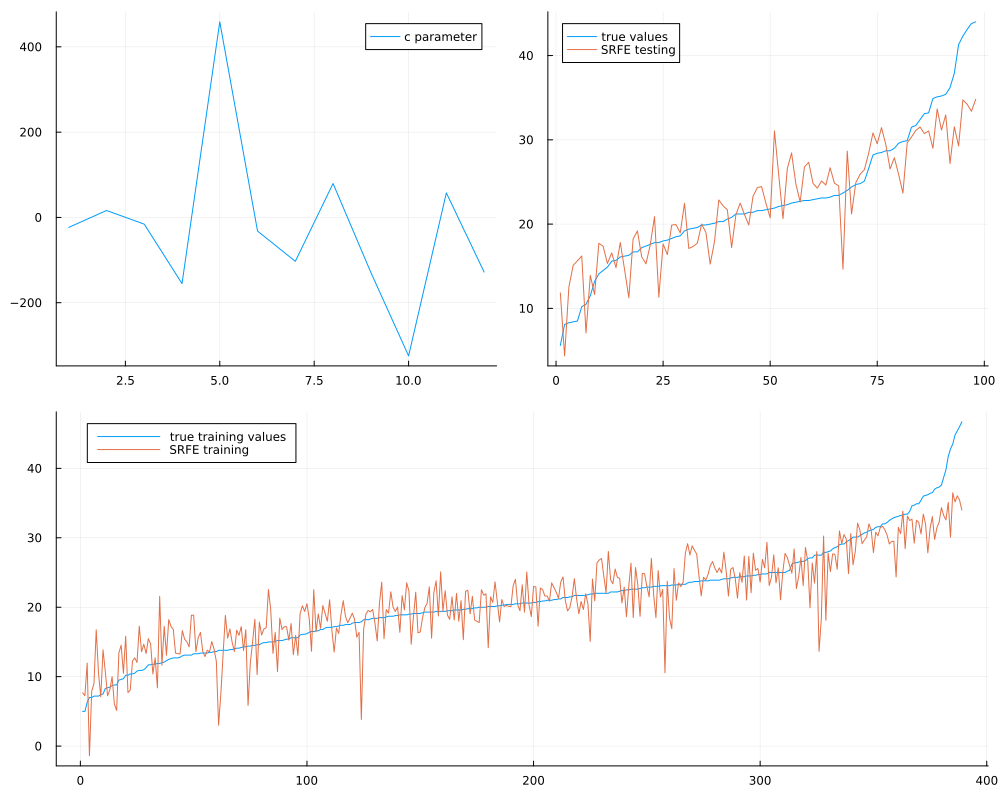

In [30]:
A = hcat(xtrain,ones(size(xtrain,1)))
# normal linear regression
c = A \ ytrain ;
# normal ridge regression
lambda = 0.00001
cRidge = (A' * A + lambda * I) \ (A'*ytrain)

ytrainpred = A * cRidge
ytestpred = hcat(xtest,ones(size(xtest,1))) * cRidge
println("")
println("test rel: ",qsrfe.rel_error(ytest,ytestpred)," train rel: ",qsrfe.rel_error(ytrain,ytrainpred))
println("test abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("test mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
model = RFE
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [ ]:
quant = βQ(K=256,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end